One of the most well known graphical modeling classes for reasoning with uncertainty is the so called Bayesian network, which relies on the Bayesian inference to answer to probabilistic queries. In a Bayesian network the variables and the conditional dependencies among them are represented by a directed acyclic graph (DAG).

## Problem

Every year the UFC needs to choose who has been the best fighter in that year per each weight category. But **how should UFC select the best fighter**?

We are going to define some evaluation criterions representing them as **boolean variables**:
The fighters are evaluated on:
- *More_wons*: more wons than loses (Yes/No)
- *Diff_category*: fought on different category (Yes/No)
- *Number_KOs*: number of KOs > 5 (Yes/No)
- *Grappling_quality*: grappling quality (Good/Bad)
- *Injuries*: injuries during the season (Yes/No)

In [1]:
from pgmpy.models import BayesianModel

## Model definition

Now we are going to define the structure of the model which means to define the relationships that exist between the previously defined variables.

In [2]:
model = BayesianModel([('More_wons', 'Best_fighter'),
                       ('Diff_category', 'Best_fighter'),
                       ('Number_KOs', 'Best_fighter'),
                       ('Injuries', 'Grappling_quality'),
                       ('Grappling_quality', 'More_wons'),
                       ('Grappling_quality', 'Number_KOs'),
                       ('Diff_category', 'Injuries')
                       ]) 

In [3]:
# Network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())

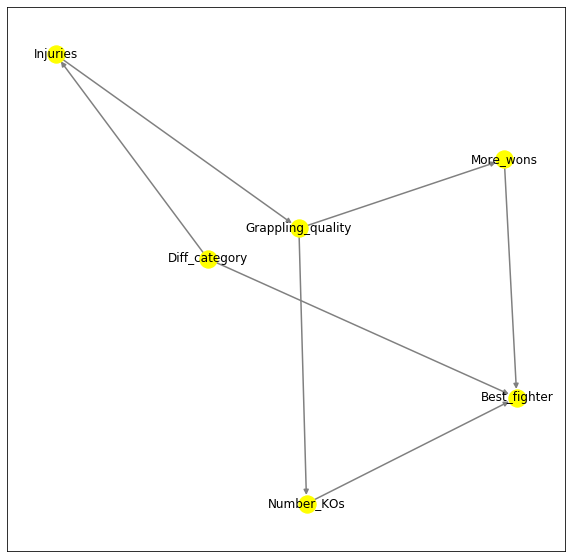

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
np.random.seed(8)

DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='yellow')
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='gray', width = 1.5, arrows=True)
plt.show()

## Conditional Probability Distribution

In order to make predictions with our model, we need to define the conditional probability distribution (CPD) of each variable.

By looking at the network shown above, we can easily conclude that:
- *Diff_category* has only a **prior probability**, thus we will have just 1 entry in the corresponding CPD tables;
- *Injuries*, *Grappling_quality*, *More_wons*, *Number_KOs* have **conditional probabilities** which means that there are 4 entries in the corresponding CPD table and for the *Best_fighter* there are 16.

In [5]:
from pgmpy.factors.discrete import TabularCPD
import numpy as np
# fought on different category
diff_category_cdp = TabularCPD('Diff_category', 2, np.array([[.7,.3]]).T)

In [6]:
# Had injureies
injuries_cpd=TabularCPD('Injuries', 2, [[.70,.3],[.3,.7]],
                       evidence=['Diff_category'],
                       evidence_card=[2])

In [7]:
# Grappling quality
grappling_quality_cpd=TabularCPD('Grappling_quality', 2, [[.7,.4],[.3,.6]],
                       evidence=['Injuries'],
                       evidence_card=[2])

In [8]:
# Has more wons than loses
more_wons_cpd=TabularCPD('More_wons', 2, [[.85,.4],[.15,.6]],
                       evidence=['Grappling_quality'],
                       evidence_card=[2])

In [9]:
# Number of KOs > 5
number_KOs_cpd=TabularCPD('Number_KOs', 2, [[.6,.2],[.4,.8]],
                       evidence=['Grappling_quality'],
                       evidence_card=[2])

In [10]:
#Not chosen/chosen to be the best fighter given Number_KOs, Diff_Category and More_wons
best_fighter_cpd=TabularCPD('Best_fighter',2,[[.95,.73,.7,.23,.35,.20,.28,.1],[.05,.27,.3,.77,.65,.8,.72,.9]],
                       evidence=['Number_KOs','Diff_category','More_wons'],
                       evidence_card=[2,2,2]) 

In [11]:
model.add_cpds(diff_category_cdp,
               injuries_cpd,
               grappling_quality_cpd,
               more_wons_cpd,
               number_KOs_cpd,
               best_fighter_cpd)

# Verify the model correctness by:
#  -checking if the sum of the probabilities for each state is equal to 1;
#  -checking if the CPDs associated with nodes are consistent with their parents.
if model.check_model():
    print("No errors in the defined model.")

No errors in the defined model.


## Inferece
There are two classes of inference methods: the *exact inference* and the *approximate inference*. In the former, we analytically compute the conditional probability distribution over the variables of interest using the posterior probability distributions. In the latter, we approximate the required posterior probability distributions using sampling methods or optimization techniques.

Thanks to the inference methods, we can execute:
- a **conditional probability query**: (i.e. asking for the probability that a node X has a particular value 𝑥 given the evidence of Y being equal to 𝑦, formally P(X=x∣Y=y));
- **a MAP query**: (i.e. asking for the most likely explanation for some evidence – Maximum A-posteriori Probability).

#### Exact Inference

A very well known algorithm to perform exact inference on graphical models is the **Variable Elimination (VE)**.
In the lines below I test VE by asking for:
- the prior probability distribution of *Best_fighter*
- the probability distribution of Best_fighter given the evidence Number_KOs "no" (< 5 namely)
- the probability distribution of Number_KOs and More_wons given Best_fighter "no"
- the MAP of the evidence Grappling_quality "Good".

In [17]:
from pgmpy.inference import VariableElimination

exact_inference = VariableElimination(model)
# the prior probability distribution of Best_fighter
query1 = exact_inference.query(['Best_fighter'])
print('\nP(Best_fighter)\n\n', query1)

Eliminating: Diff_category: 100%|██████████| 5/5 [00:00<00:00, 373.21it/s]


P(Best_fighter)

 +-----------------+---------------------+
| Best_fighter    |   phi(Best_fighter) |
+=================+=====================+
| Best_fighter(0) |              0.4966 |
+-----------------+---------------------+
| Best_fighter(1) |              0.5034 |
+-----------------+---------------------+


In [18]:
# the probability distribution of Best_fighter given the evidence Number_KOs "no" (< 5 namely)
query2 = exact_inference.query(['Best_fighter'],{'Number_KOs':0})
print('\n\nP(Best_fighter|Number_KOs= \"no\" )\n\n', query2)

Eliminating: Grappling_quality: 100%|██████████| 4/4 [00:00<00:00, 532.14it/s]



P(Best_fighter|Number_KOs=no)

 +-----------------+---------------------+
| Best_fighter    |   phi(Best_fighter) |
+=================+=====================+
| Best_fighter(0) |              0.8098 |
+-----------------+---------------------+
| Best_fighter(1) |              0.1902 |
+-----------------+---------------------+


In [19]:
# the probability distribution of Number_KOs and More_wons given Best_fighter "no"
query3 = exact_inference.query(['Number_KOs', 'More_wons'], {'Best_fighter':0})
print('\n\nP(Number_KOs, More_wons|Best_fighter= \"no\"" )\n\n', query3)

Eliminating: Grappling_quality: 100%|██████████| 3/3 [00:00<00:00, 552.12it/s]



P(Number_KOs, More_wons|Best_fighter=no)

 +---------------+--------------+-----------------------------+
| Number_KOs    | More_wons    |   phi(Number_KOs,More_wons) |
+===============+==============+=============================+
| Number_KOs(0) | More_wons(0) |                      0.5814 |
+---------------+--------------+-----------------------------+
| Number_KOs(0) | More_wons(1) |                      0.1193 |
+---------------+--------------+-----------------------------+
| Number_KOs(1) | More_wons(0) |                      0.2197 |
+---------------+--------------+-----------------------------+
| Number_KOs(1) | More_wons(1) |                      0.0797 |
+---------------+--------------+-----------------------------+


In [22]:
# the MAP of the evidence Grappling_quality "Good".
query4 = exact_inference.map_query(['Best_fighter', 'Number_KOs', 'Diff_category'], {'Grappling_quality':1}) 
print('\n\nMAP of Grappling_quality = \"Good\" \n\n',query4)

Eliminating: More_wons: 100%|██████████| 2/2 [00:00<00:00, 312.82it/s]



MAP of Grappling_quality = "Good" 

 {'Best_fighter': 1, 'Number_KOs': 1, 'Diff_category': 0}


#### Approximate inference
The main problem in performing exact inference is that it’s carried out with posterior probabilities which are not always tractable. The approximate inference addresses this issue by sampling form the untractable posterior (stochastic methods) or by approximating the posterior with a tractable distribution (deterministic methods).

In the lines below I compare three sampling methods (Weighted Likelihood (WL), Rejection Sampling (RS) and Gibbs Sampling (GS)) using the VE result as reference. 
I query the model for *P*(Injuries="yes" ∣ Diff_category="yes", Best_fighter="no") and I run 10 experiments with an increasing number of samples.

In [23]:
query = exact_inference.query(['Injuries'], {'Diff_category' : 1,'Best_fighter' : 0})
print("\nP(Injuries | Diff_category = \"yes\", Best_fighter = \"no\")\n\n", query)

reference_prob = query.values[1]

Eliminating: More_wons: 100%|██████████| 3/3 [00:00<00:00, 797.70it/s]


P(Injuries | Diff_category = "yes", Best_fighter = "no")

 +-------------+-----------------+
| Injuries    |   phi(Injuries) |
+=============+=================+
| Injuries(0) |          0.3467 |
+-------------+-----------------+
| Injuries(1) |          0.6533 |
+-------------+-----------------+


In [24]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.sampling import GibbsSampling

BMS_inference = BayesianModelSampling(model)
gibbs = GibbsSampling(model)

def prob_WL(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def prob_Gibbs(samples):
    return (samples.query('Injuries == 1 & Diff_category == 1 & Best_fighter == 0').shape[0]
                /
            samples.query('Diff_category == 1 & Best_fighter == 0').shape[0])
    
def run_experiment(sample_size):
    # Sample
    samples_WL = BMS_inference.likelihood_weighted_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')
    samples_RS = BMS_inference.rejection_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')
    samples_GS= gibbs.sample(size = size)
    
    # Probability
    results_WL = prob_WL(samples_WL,'Injuries')
    results_RS = np.recarray.mean(samples_RS['Injuries'], axis=0)
    results_GS = prob_Gibbs(samples_GS)
    
    # Return results
    return np.array([(sample_size, 
                      results_WL,
                      results_RS,
                      results_GS)], 
                    dtype=[('sample_size', '<i8'), 
                           ('WL', '<f8'),
                           ('RS', '<f8'),
                           ('GS', '<f8')])

In [45]:
approximate_results = np.array([], dtype=[('sample_size', '<i8'), 
                           ('WL', '<f8'),
                           ('RS', '<f8'),
                           ('GS', '<f8')])
initial_size = 2
final_size = 5
num = 10
evidence = [State('Diff_category',1), State('Best_fighter',0)]

In [26]:
for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    approximate_results=np.append(approximate_results,run_experiment(size))

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 345.49it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 135.97it/s]
178it [00:00, 2643.89it/s]             
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 199.66it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 75.10it/s]
337it [00:00, 2838.80it/s]             
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 172.23it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 47.76it/s]
703it [00:00, 4016.02it/s]             
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 104.09it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 26.79it/s]
1357it [00:00, 4658.69it/s]             
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 80.27it/s]

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:00<00:00, 14.14it/s]
3026it [00:00, 5948

Generating for node: Best_fighter: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]
14440it [00:02, 7171.16it/s]                          
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]
30707it [00:04, 7521.07it/s]                          
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]
66010it [00:08, 7907.56it/s]                          
Generating for node: Best_fighter: 100%|██████████| 6/6 [00:16<00:00,  2.71s/it]
140465it [00:18, 7682.38it/s]                           
100%|██████████| 99999/99999 [00:35<00:00, 2829.65it/s]


In [33]:
sizes = approximate_results['sample_size']
results_WL = approximate_results['WL']
results_RS = approximate_results['RS']
results_GS = approximate_results['GS']

Now we are going to check which is the method that produces the value closer the *reference value*:

In [61]:
def get_best_sampling_method(reference_prob, results_WL, results_RS, results_GS):
    wl = abs(reference_prob - results_WL[-1])
    rs = abs(reference_prob - results_RS[-1])
    gs = abs(reference_prob - results_GS[-1])
    if wl < rs and wl < gs:
        print("The best method is WL with a difference wrt the reference value of: {}".format(wl))
    elif rs < wl and rs < gs:
        print("The best method is RS with a difference wrt the reference value of: {}".format(rs))
    else:
        print("The best method is GS with a difference wrt the reference value of: {}".format(gs))

In [62]:
get_best_sampling_method(reference_prob, results_WL, results_RS, results_GS)

The best method is RS with a difference wrt the reference value of 0.00022665746691097333
